In [12]:
import cv2
import numpy as np
import torch
import torchvision

In [13]:
seed = 1024

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
batch_size=16
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device Used :", device)

Device Used : cuda


In [2]:
import os
import json
import math

# For container dataset
x_dir = '../container_dataset/container_dataset/train_images/'
y_dir = '../container_dataset/container_dataset/train_labels/'

data = []

len_list = []
size_list = []

for filename in os.listdir(y_dir):
    f = os.path.join(y_dir, filename)

    if not os.path.isfile(f):
        continue

    label_json = open(f)
    label_dict = json.load(label_json)

    labels_list = [(i['properties']['object_imcoords'], i['properties']['object_angle']) for i in label_dict['features']]
    property_list = []
    coords_list = []

    for coords, angle in labels_list:
        coords = [float(k) for k in coords.split(',')]
        # print(coords)

        side_len1 = abs(coords[0] - coords[2])**2 + abs(coords[1] - coords[3])**2
        side_len1 = math.sqrt(side_len1)
        side_len2 = abs(coords[0] - coords[6])**2 + abs(coords[1] - coords[7])**2
        side_len2 = math.sqrt(side_len2)

        mid_x = (coords[0] + coords[4]) / 2
        mid_y = (coords[1] + coords[5]) / 2

        property_list.append((side_len1, side_len2, mid_x, mid_y, angle))
        coords_list.append(coords)

        size_list.append(side_len1 * side_len2)
    
    len_list.append(len(property_list))

    data.append((os.path.join(f), property_list, coords_list))

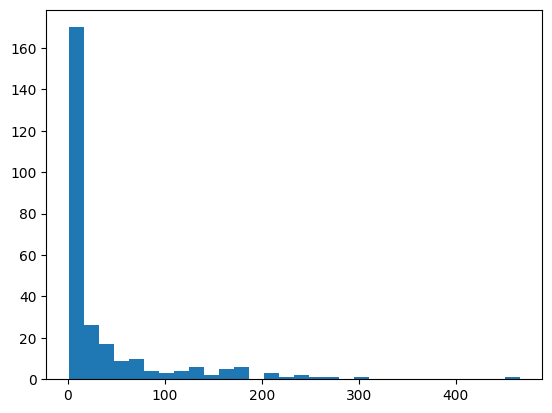

In [3]:
import matplotlib.pyplot as plt

# print(len_list)

plt.hist(len_list, bins=30)
plt.show()

# Number of Objects range up to ~500. Most images have less than 200

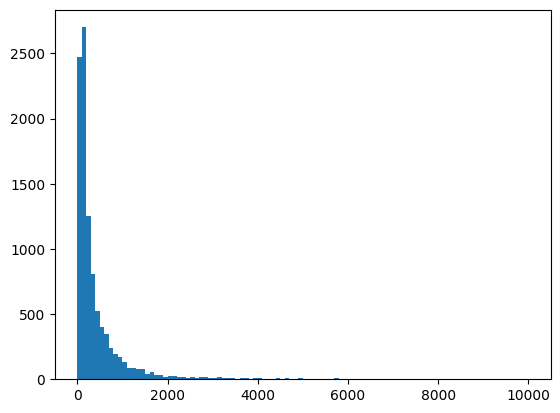

In [4]:
plt.hist(size_list, bins=100, range=[0, 10000])
plt.show()

# Object Size Histogram

In [5]:
img_data = []

for data_point in data:
    tmp_name = (data_point[0][:-4] + 'png').split('/')
    tmp_name[-2] = 'train_images'
    
    filename = '/'.join(tmp_name)
    
    img_data.append((filename, data_point[1], data_point[2]))

In [6]:
class property_Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self._data_list = data
    
    def __len__(self):
        return len(self._data_list)

    def __getitem__(self, index):
        return (self._data_list[index][0], self._data_list[index][1])
    
class coords_Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self._data_list = data
    
    def __len__(self):
        return len(self._data_list)
    
    def __getitem__(self, index):
        return (self._data_list[index[0]], self._data_list[index][2])

In [7]:
import random

random.shuffle(img_data)

validation_ratio = 0.1
testing_ratio = 0.1

data_count = len(img_data)
validation_thresh = int(data_count * (1 - (validation_ratio + testing_ratio)))
testing_thresh = int(data_count * (1 - testing_ratio))

train_data = img_data[:validation_thresh]
val_data = img_data[validation_thresh:testing_thresh]
test_data = img_data[testing_thresh:]

print("Training Data", len(train_data), "samples initialized...")
print("Validation Data", len(val_data), "samples initialized...")
print("Testing Data", len(test_data), "samples initialized...")

Training Data 217 samples initialized...
Validation Data 27 samples initialized...
Testing Data 28 samples initialized...


In [8]:
data_type = "property"

if data_type == "property":
    train_data = property_Dataset(train_data)
    val_data = property_Dataset(val_data)
    test_data = property_Dataset(test_data)
elif data_type == "coords":
    train_data = coords_Dataset(train_data)
    val_data = coords_Dataset(val_data)
    test_data = coords_Dataset(test_data)

In [9]:
from torchvision import transforms
from torchvision.io import read_image

# for RGB values
def collate_img_notransform(data):
    image_batch = []
    target_batch = []

    for img_path, target in data:
        img_path = os.path.join(os.getcwd(), img_path)

        if not os.path.exists(img_path):
            print(f'no image: {img_path}')
            continue
        
        raw_image = read_image(img_path).to(torch.float)

        # print(type(raw_image))
        # print(raw_image.shape)

        image_preprocess = transforms.Compose([
            # transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        image = image_preprocess(raw_image)

        image_batch.append(image)

        target = [torch.Tensor(t).to(torch.float) for t in target]

        target_batch.append(target)

        
    
    images = torch.stack(image_batch)

    return images, target_batch

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, drop_last=True, collate_fn=collate_img_notransform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, drop_last=True, collate_fn=collate_img_notransform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, drop_last=True, collate_fn=collate_img_notransform)

In [ ]:
optimizer = torch.optim.AdamW()
scheduler = torch.optim.lr_scheduler.StepLR(opti)

In [11]:
for train_batch in train_loader:
    train_x, train_y = train_batch
    train_x.to(device)
    train_y = [[y_var.to(device) for y_var in y_batch_var] for y_batch_var in train_y]